In [ ]:
# Install Playwright
!pip install playwright
!playwright install chromium

from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import asyncio
import re
import numpy as np
import random

async def scrape_page(url, dataSet='humanEval'):

    async with async_playwright() as p:
        # Launch browser
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Navigate to the page
        await page.goto(url)

        # Wait for potential dynamic content
        await page.wait_for_timeout(5000)
        if dataSet=='mbpp':
          await page.click('label[for="MBPP"]')
          # Wait for content to load after selection
          await page.wait_for_timeout(3000)  # Adjust this time if necessary

        # Get page content
        page_content = await page.content()

        # Close browser
        await browser.close()

        return page_content

async def fetchData(dataSet='humanEval'):
    extracted_data = []
    success_rate_pattern = re.compile(r'⚡\s*([\d\.]+)')

    try:
        # URL to scrape
        url = "https://evalplus.github.io/leaderboard.html"

        # Get page content
        page_content = await scrape_page(url,dataSet)

        soup = BeautifulSoup(page_content, 'html.parser')

        # Search for the <a> tags with the specific class
        links = soup.find_all('a', class_='link-underline-primary text-nowrap')
        print(f"Number of links found: {len(links)}")

        # Loop through the links and extract their names, URLs, and corresponding 'success' data
        for link in links:
            # Ensure link has href and text
            if link and link.get('href') and link.text:
                # Find the parent <tr> of the <a> tag
                parent_tr = link.find_parent('tr')

                # Find the <td> with class 'success' within the same <tr>
                success_td = parent_tr.find('td', class_='text-success')


                # Ensure the success_td exists
                if success_td:
                    # Print the model name, URL, and success data
                    success_rate_match = success_rate_pattern.search(success_td.text.strip())
                    success_rate = float(success_rate_match.group(1)) if success_rate_match else None
                    extracted_data.append({
                        'model_name': link.text.strip(),
                        'success_data': success_rate
                    })


        return extracted_data
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the async main function


In [ ]:

cleaned_data = []

pattern = re.compile(r'(\d+)[Bb]')

async def fetchAndCleanData(dataset):
  cleaned_data.clear()
  for model in await fetchData(dataset):
    match = pattern.search(model['model_name'])
    billion_parameters = int(match.group(1)) if match else None
    if billion_parameters != None :
      cleaned_data.append({
          'parameters': billion_parameters,
          'success_rate': model["success_data"]
      })
  print("fetched and cleaned data",len(cleaned_data))


#Partie 1 : Impact de la Taille des Modèles
Dans cette partie, nous examinerons comment la taille des modèles influence leurs performances en génération de code.

Cette analyse est essentielle pour comprendre si des modèles plus grands offrent systématiquement de meilleures performances, ou si les gains diminuent au-delà d'une certaine échelle. Existe-t-il des scénarios où les modèles plus petits pourraient rivaliser avec les modèles plus grands ?

In [ ]:
import matplotlib.pyplot as plt
def plotData():
  # Extract parameters and success rates from cleaned_data
  parameters = [item['parameters'] for item in cleaned_data]
  success_rates = [item['success_rate'] for item in cleaned_data]

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.scatter(parameters, success_rates, color='blue', edgecolors='black')

  # Add labels and titles
  plt.xlabel('Number of Parameters (in billions)')
  plt.ylabel('Benchmark Score pass@1')
  plt.title('Model Parameters vs. benchmark score ')
  plt.grid(True)
  plt.show()


Number of links found: 248
fetched and cleaned data 98


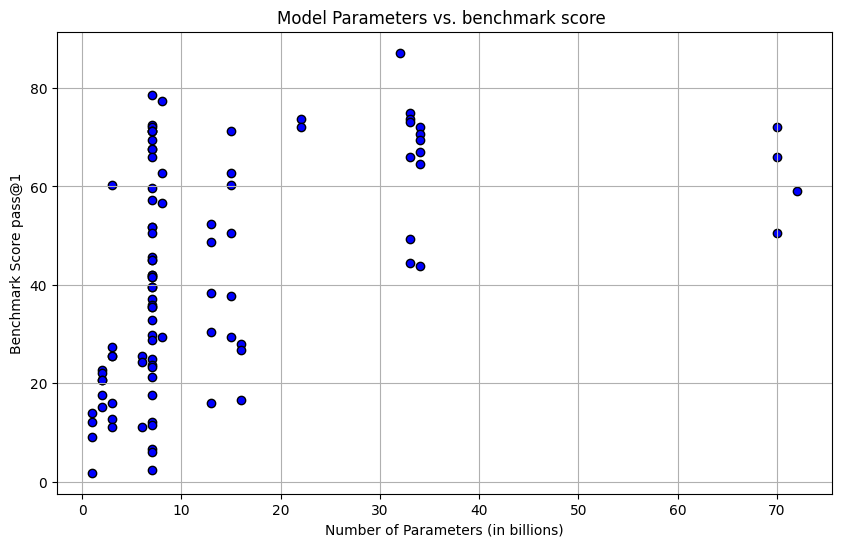

In [ ]:
await fetchAndCleanData('humanEval')
plotData()

* La taille du modèle (en paramètres) n'est pas directement liée aux performances
* Certains petits modèles atteignent des scores similaires aux grands modèles
* Les meilleurs résultats se trouvent autour de 30-35 milliards de paramètres, avec des scores entre 65 et 85
* Les modèles de 0-10 milliards de paramètres montrent une grande variation dans leurs performances, allant de très faibles à très bonnes
* Au-delà de 35 milliards de paramètres, on ne voit pas d'amélioration significative des performances, suggérant qu'une architecture optimisée est plus importante que la taille

#Partie 2 : Évolution des Performances sur Différents DataSet ( HumanEval et Mbpp comme exemples )
dans cette partie nous allons montrer et analyser la difference en preformance sur ces deux datasets des problem en utilisant le meme benchmark evalPlus pour chaque modele.

Bien que la majorité des avis considèrent HumanEval comme plus difficile, jusqu’à quel point cette difficulté se manifeste-t-elle ? Est-ce que cela s'applique uniformément à tous les modèles ? Existe-t-il des facteurs spécifiques qui pourraient modifier cette conclusion ?

Ces questions sont essentielles pour affiner notre compréhension des impacts des datasets sur les LLMs de génération de code.

In [ ]:
def plot_model_comparison(human_eval_data, mbpp_data):
    # Extract model names and scores from the data
    # Create dictionaries for easier lookup
    he_dict = {item['model_name']: item['success_data'] for item in human_eval_data}
    mb_dict = {item['model_name']: item['success_data'] for item in mbpp_data}

    # Get all unique model names
    models = list(set(he_dict.keys()) | set(mb_dict.keys()))
    models.sort()  # Sort for consistent ordering

    # Create arrays of scores
    he_scores = np.array([he_dict.get(model, 0) for model in models])
    mb_scores = np.array([mb_dict.get(model, 0) for model in models])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set width and positions for bars
    width = 0.35
    x = np.arange(len(models))

    # Create bars
    bars1 = ax.bar(x - width/2, he_scores, width, label='HumanEval', color='#8884d8')
    bars2 = ax.bar(x + width/2, mb_scores, width, label='MBPP', color='#82ca9d')

    # Add difference highlights and percentage labels
    for i in range(len(models)):
        he_score = he_scores[i]
        mb_score = mb_scores[i]
        diff = abs(he_score - mb_score)

        if he_score > mb_score:
            # Add highlight above HumanEval bar
            ax.bar(x[i] - width/2, diff, width,
                   bottom=mb_score,
                   color='#ff9999',
                   alpha=0.6)
            # Add percentage label
            ax.text(x[i] - width/2, he_score + 1,
                    f'+{diff:.1f}%',
                    ha='center',
                    va='bottom')
        elif mb_score > he_score:
            # Add highlight above MBPP bar
            ax.bar(x[i] + width/2, diff, width,
                   bottom=he_score,
                   color='#ff9999',
                   alpha=0.6)
            # Add percentage label
            ax.text(x[i] + width/2, mb_score + 1,
                    f'+{diff:.1f}%',
                    ha='center',
                    va='bottom')

    # Customize the plot
    ax.set_ylabel('Success Rate (%)')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    # Add grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent label clipping
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
    human_eval_data = await fetchData("humanEval")
    mbpp_data = await fetchData("mbpp")

Number of links found: 248
Number of links found: 176


In [ ]:
def plotByRange(bottomBorder, upperBorder):
  # Sort by HumanEval score (you can change to MBPP if preferred)
  sorted_models = sorted(mbpp_data,
                        key=lambda x: x['success_data'],
                        reverse=True)  # Higher scores first

  # Take top 20 models
  top_model_names = [item['model_name'] for item in sorted_models[bottomBorder:upperBorder]]

  # Filter both datasets to include only top models
  he_filtered = [item for item in human_eval_data if item['model_name'] in top_model_names]
  mb_filtered = [item for item in mbpp_data if item['model_name'] in top_model_names]
  print(len(he_filtered))
  print(len(mb_filtered))
  # Sort filtered data by HumanEval score for consistent display
  he_filtered.sort(key=lambda x: x['success_data'], reverse=True)
  mb_filtered = sorted(mb_filtered,
                      key=lambda x: next(item['success_data'] for item in he_filtered
                                        if item['model_name'] == x['model_name']),
                      reverse=True)

  # Plot using the original function
  plot_model_comparison(he_filtered, mb_filtered)



20
20


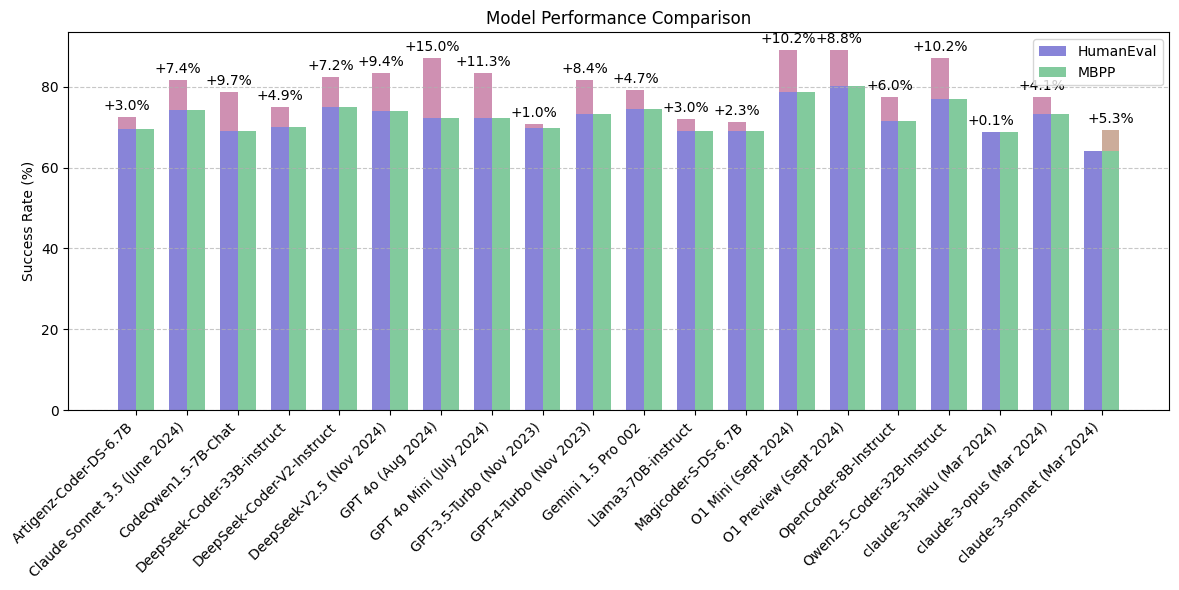

20
20


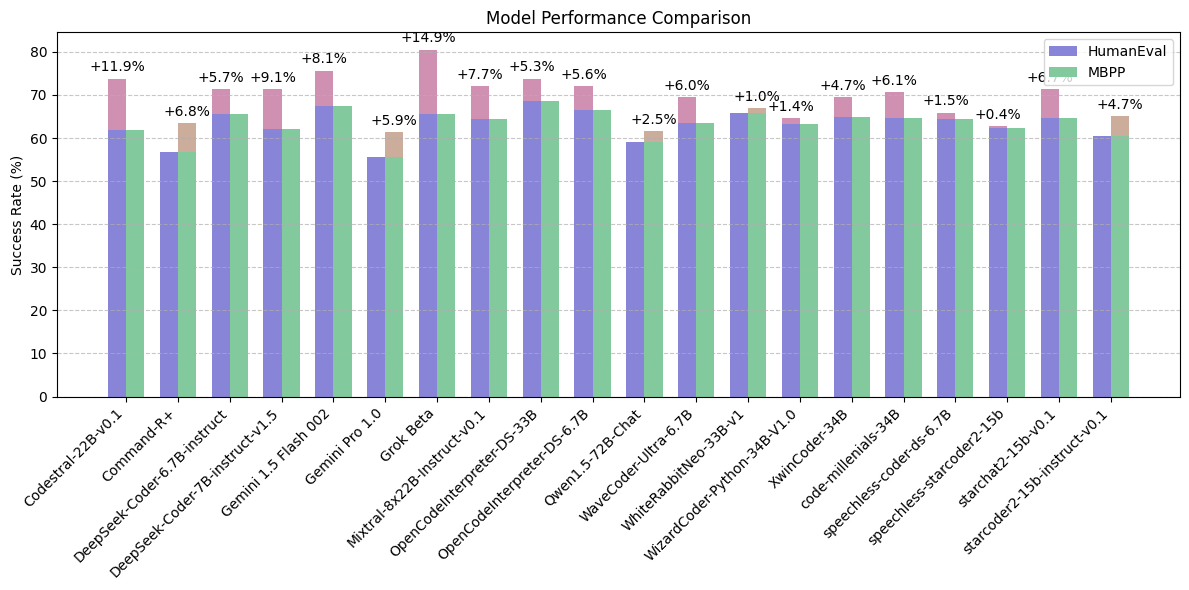

20
20


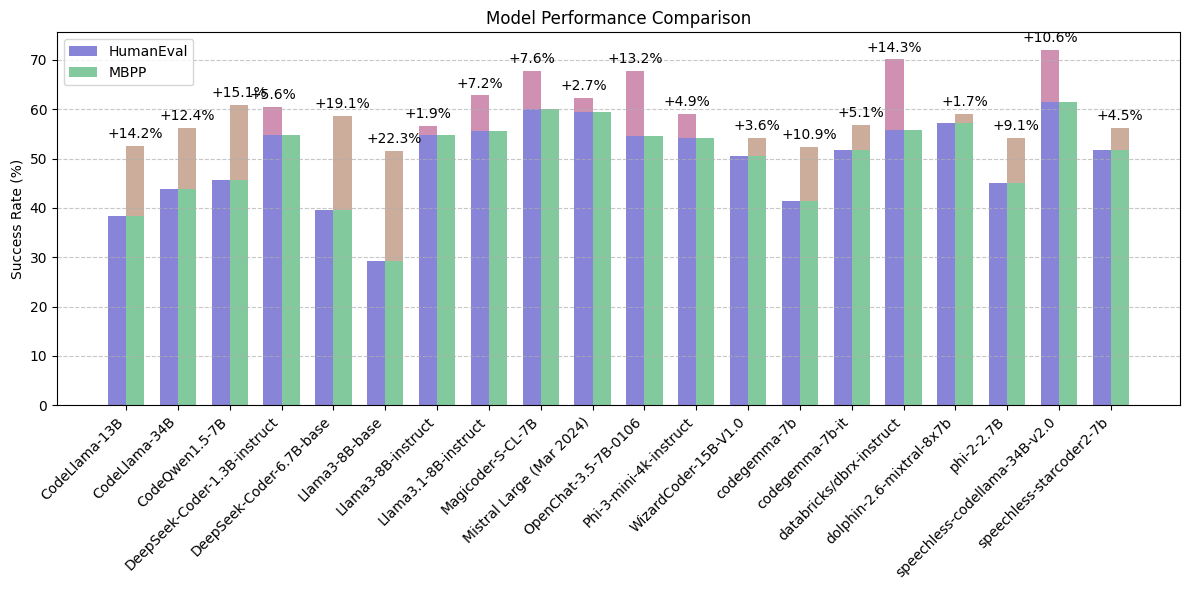

In [ ]:
plotByRange(0, 20)
plotByRange(20, 40)
plotByRange(40, 60)

* Il y a une évolution claire des performances entre les modèles plus anciens (scores autour de 30-50%) et les plus récents (scores >60%), montrant une amélioration significative au fil du temps
* La différence de performance entre MBPP et HumanEval est moins prononcée dans les modèles récents, suggérant une meilleure généralisation sur différents types de tâches de codage
* Les améliorations notables (+10-15%) sont surtout visibles dans certains sauts générationnels, comme pour CodeGen, DeepSeek et Mistral, montrant l'impact des avancées architecturales
* Les modèles récents maintiennent des performances plus stables entre les deux benchmarks (différences de 5-10%), alors que les anciens modèles montraient plus de variations